# European quarterly retail trade

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import scipy.stats
import pylab

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller,grangercausalitytests,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.api import VAR

from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot,quarter_plot
from statsmodels.tools.eval_measures import mse,rmse,meanabs

from pmdarima import auto_arima

In [2]:
raw_data = pd.read_csv("euretail.csv")
raw_data.head()

,x
0,89.13
1,89.52
2,89.88
3,90.12
4,89.19


In [3]:
df = raw_data.copy()
len(df)

64

In [4]:
df.index = pd.date_range("2000-01-01",periods=64,freq="Q")

In [5]:
df.head()

,x
2000-03-31,89.13
2000-06-30,89.52
2000-09-30,89.88
2000-12-31,90.12
2001-03-31,89.19


In [6]:
df.isnull().sum()

x    0
dtype: int64

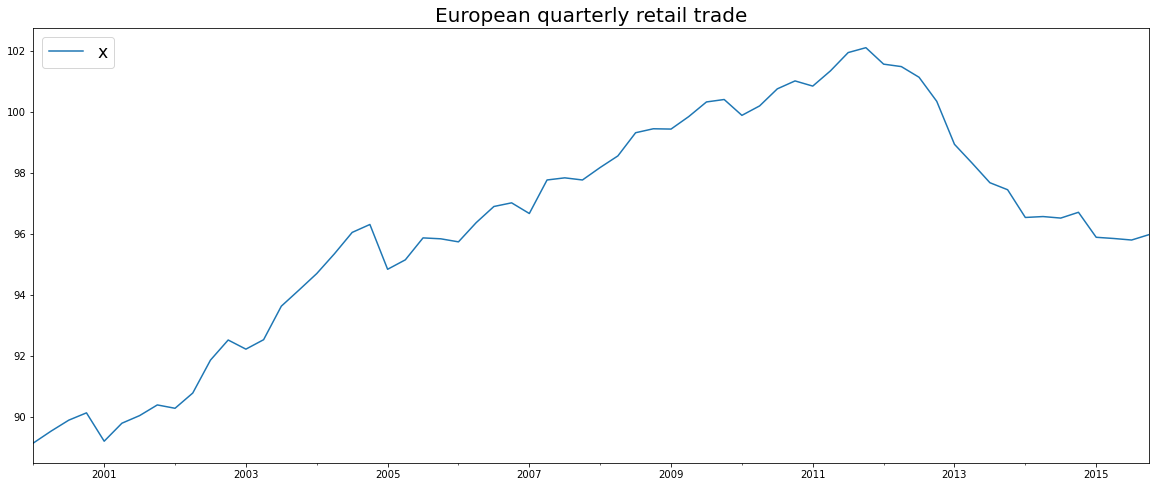

In [7]:
df.plot(figsize=(20,8))
plt.title("European quarterly retail trade",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

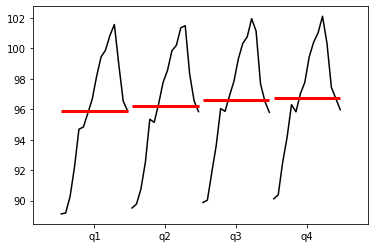

In [8]:
df_q = df.x.resample(rule="Q").mean()
quarter_plot(df_q);

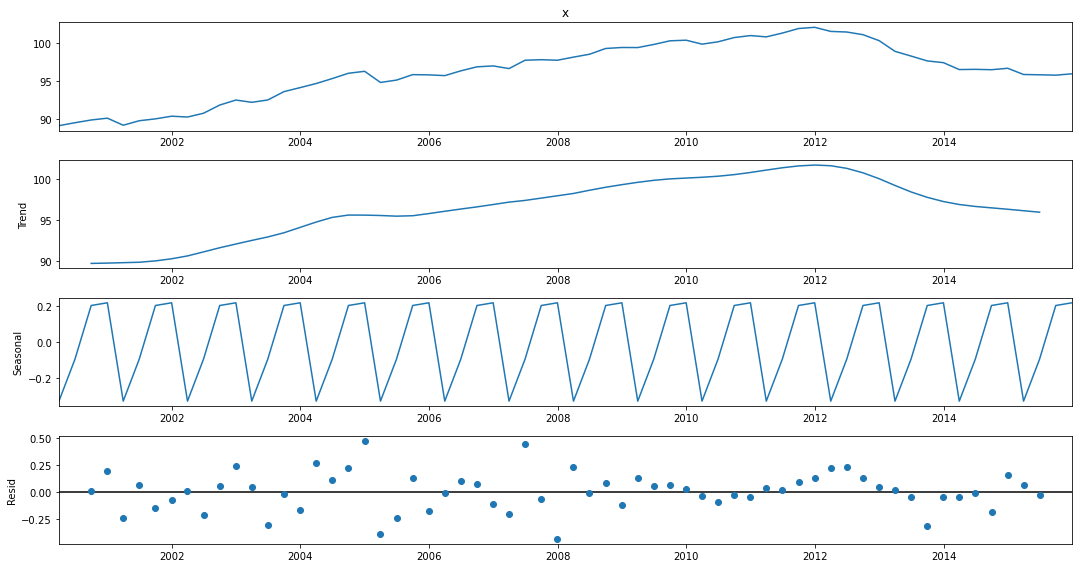

In [9]:
result = seasonal_decompose(df.x,model="add")  
rcParams["figure.figsize"] = 15,8
result.plot();

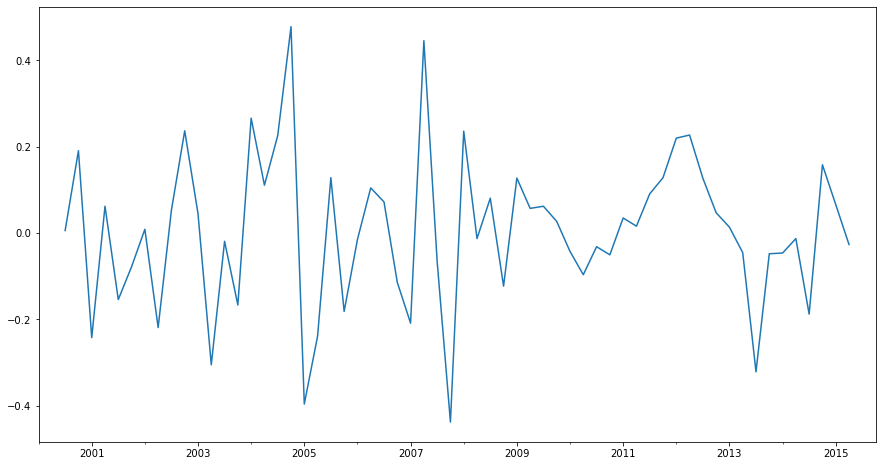

In [10]:
result.resid.plot();

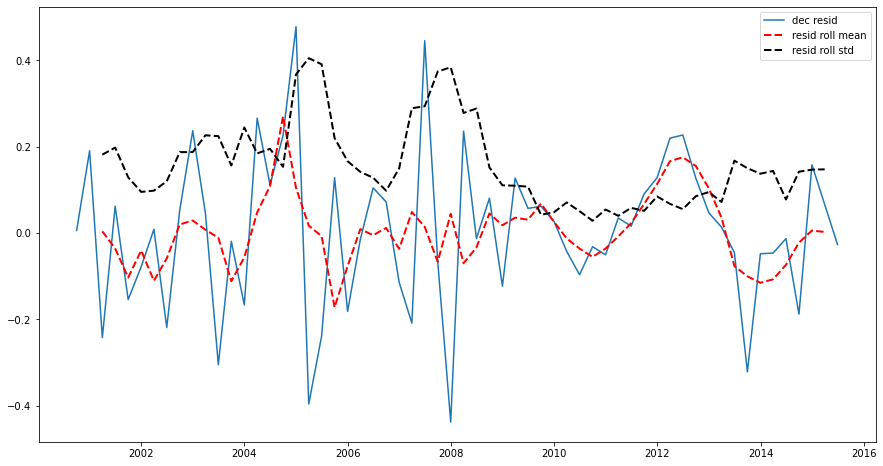

In [11]:
ar = result.resid
rolm = pd.Series.rolling(ar, window = 4, center = True).mean()
rolstd = pd.Series.rolling(ar, window = 4, center = True).std()
plt.plot(result.resid, label = 'dec resid')
plt.plot(rolm, label = 'resid roll mean', linestyle = '--',lw=2,c="r")
plt.plot(rolstd, label = 'resid roll std', linestyle = '--',lw=2,c="black")
plt.legend()
plt.show()

In [12]:
def adf_test(series):

    print(f'Augmented Dickey-Fuller Test:')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [13]:
adf_test(df.x)

Augmented Dickey-Fuller Test:
ADF test statistic      -2.300304
p-value                  0.171870
# lags used              8.000000
# observations          55.000000
critical value (1%)     -3.555273
critical value (5%)     -2.915731
critical value (10%)    -2.595670
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


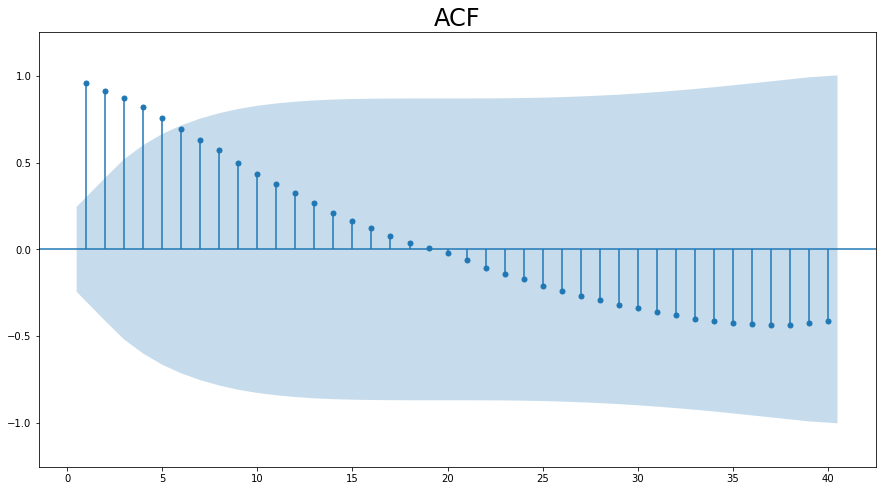

In [14]:
plot_acf(df.x,lags=40,zero=False,auto_ylims=True)
plt.title("ACF",size=24)
plt.show()

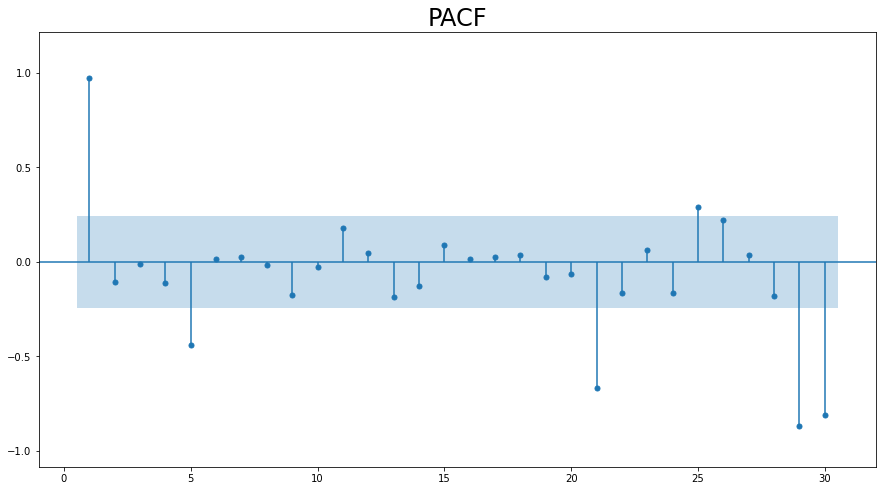

In [15]:
plot_pacf(df.x,lags=30,zero=False,auto_ylims=True)
plt.title("PACF",size=24)
plt.show()

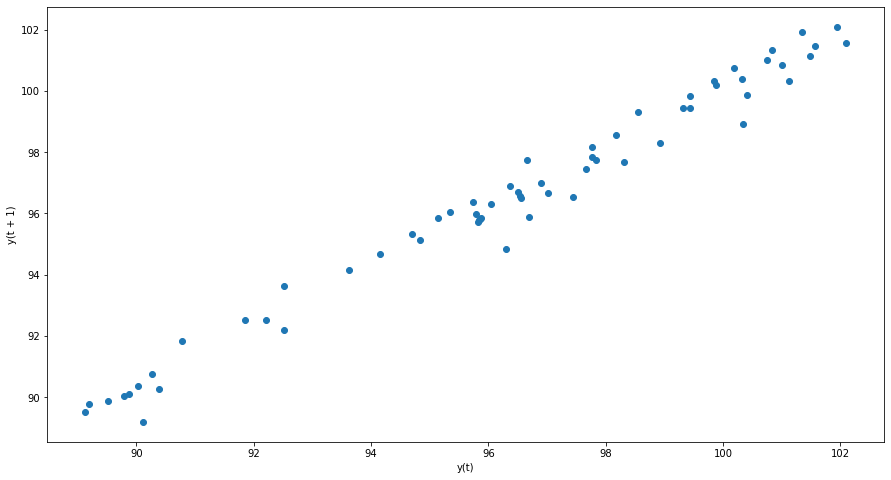

In [16]:
lag_plot(df.x);

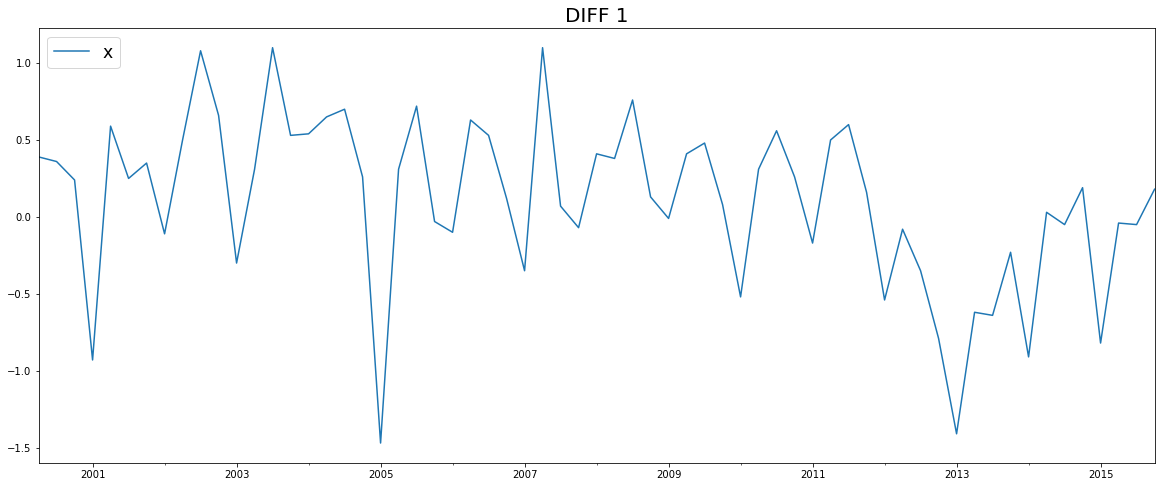

In [17]:
diff1 = diff(df.x,k_diff=1)

diff1.plot(figsize=(20,8))
plt.title("DIFF 1",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

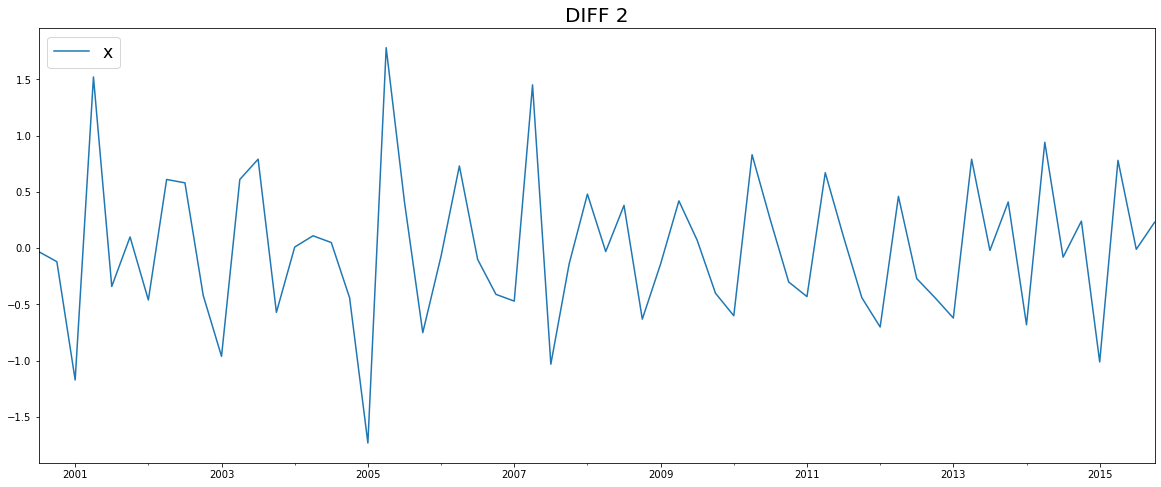

In [18]:
diff2= diff(df.x,k_diff=2)

diff2.plot(figsize=(20,8))
plt.title("DIFF 2",fontsize=20)
plt.legend(loc="upper left",fontsize="xx-large")
plt.show()

In [19]:
adf_test(diff1)

Augmented Dickey-Fuller Test:
ADF test statistic      -1.225897
p-value                  0.662358
# lags used              7.000000
# observations          55.000000
critical value (1%)     -3.555273
critical value (5%)     -2.915731
critical value (10%)    -2.595670
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
adf_test(diff2)

Augmented Dickey-Fuller Test:
ADF test statistic      -5.028866
p-value                  0.000019
# lags used              6.000000
# observations          55.000000
critical value (1%)     -3.555273
critical value (5%)     -2.915731
critical value (10%)    -2.595670
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
diff2 = pd.DataFrame(diff2)

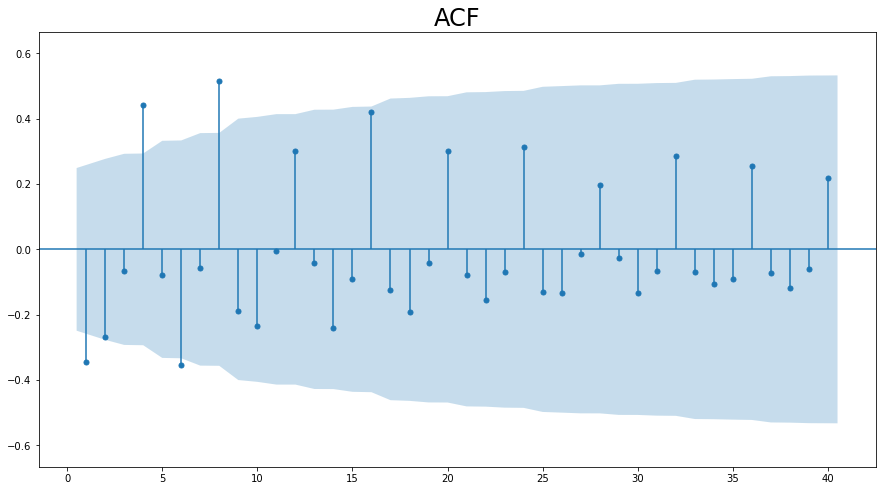

In [22]:
plot_acf(diff2.x,lags=40,zero=False,auto_ylims=True)
plt.title("ACF",size=24)
plt.show()

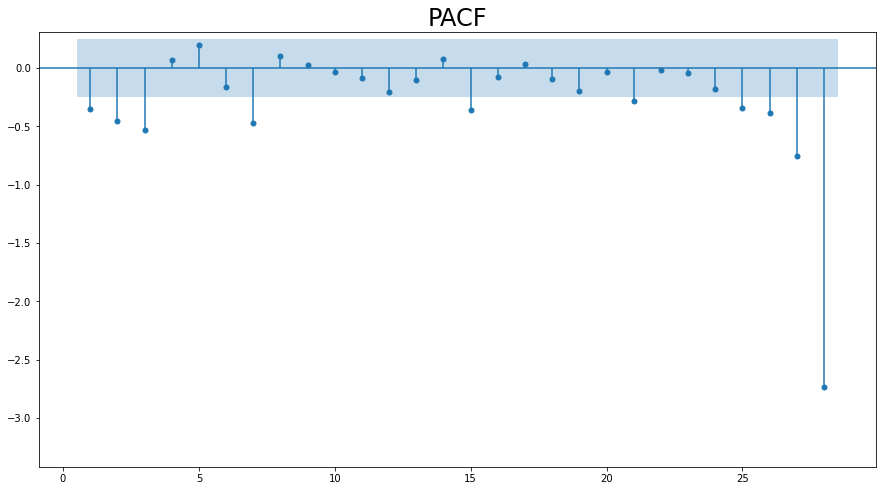

In [23]:
plot_pacf(diff2.x,lags=28,zero=False,auto_ylims=True)
plt.title("PACF",size=24)
plt.show()

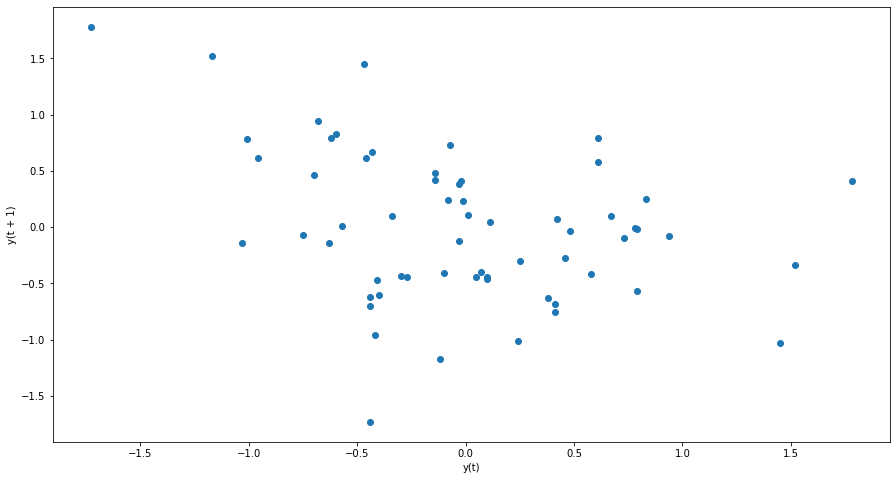

In [24]:
lag_plot(diff2.x);

In [25]:
size = -5
df_train = df[:size]
df_test = df[size:]

In [26]:
stepwise_fit = auto_arima(df_train.x,m=4, d=1,D=1,
                          seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=91.473, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=73.706, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=73.256, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=90.744, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=75.252, Time=0.05 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=75.253, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=76.598, Time=0.02 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=76.125, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=77.518, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=71.793, Time=0.03 sec
 ARIMA(0,1,2)(0,1,0)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(1,1,1)[4]             : AIC=73.650, Time=0.16 sec
 ARIMA(0,1,2)(0,1,2)[4]             : AIC=73.716, Time=0.09 sec
 ARIMA

In [27]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   59
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 4)   Log Likelihood                 -27.734
Date:                             Wed, 01 Mar 2023   AIC                             65.468
Time:                                     16:24:21   BIC                             75.412
Sample:                                 03-31-2000   HQIC                            69.303
                                      - 09-30-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2961      0.135      2.193      0.028       0.031       0.561
ma.L2          0.3496      0.124      2.827      0.005       0.107       0.592
ma.L3          0.4422      0.131      3.366      0.001       0.185       0.700
ma.S.L4       -0.7122      0.172     -4.145      0.000      -1.049      -0.375
sigma2         0.1504      0.032      4.699      0.000       0.088       0.213
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.99   Prob(JB):                         0.69
Heteroskedasticity (H):               0.55   Skew:                             0.27
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

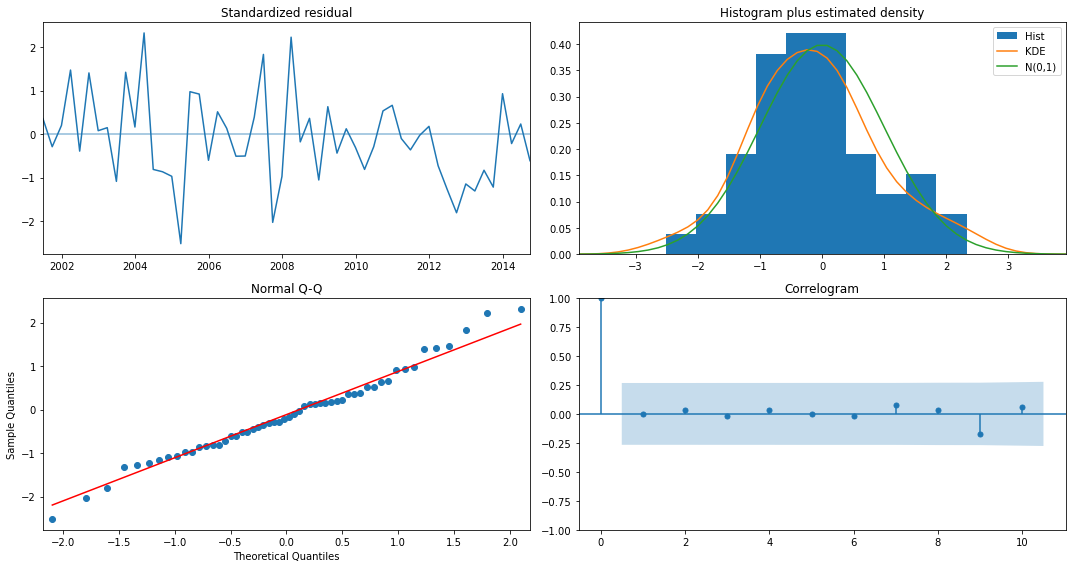

In [28]:
stepwise_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

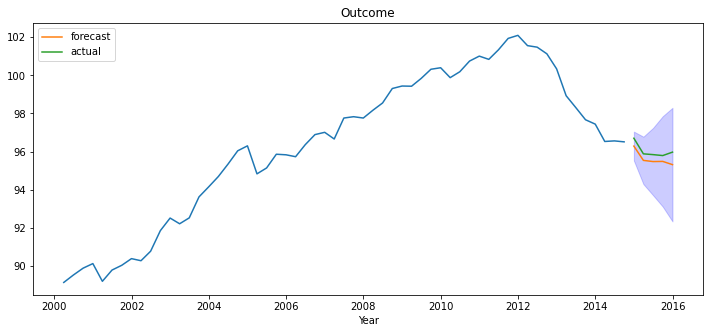

In [29]:
preds, conf_int = stepwise_fit.predict(n_periods = df_test.shape[0], return_conf_int = True)

x_axis = df_test.index

plt.figure(figsize = (12,5))
plt.plot(df_train.x)
plt.plot(preds, label = "forecast")  
plt.plot(df_test, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Year")
plt.show()

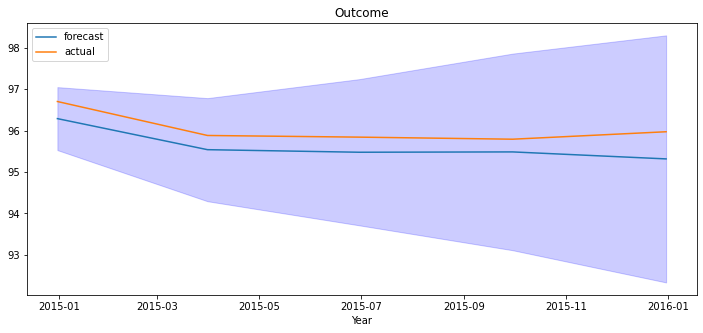

In [30]:
plt.figure(figsize = (12,5))
plt.plot(preds, label = "forecast")  
plt.plot(df_test, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Year")
plt.show()

In [31]:
def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        time_series (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Returns:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df

obtain_adf_kpss_results(df, 6)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,1.718698e-01,0.01,False,False,False
1,1,6.623576e-01,0.01,False,False,False
2,2,1.945163e-05,0.10,True,True,True
3,3,3.594117e-06,0.10,True,True,True
4,4,4.617923e-07,0.10,True,True,True
5,5,3.610387e-07,0.10,True,True,True


In [32]:
resids = preds - df_test.x

In [33]:
print('Root Mean Squared Error:', np.sqrt(np.mean(resids**2)))

Root Mean Squared Error: 0.43470283916196867


# ROLLING FORECAST

In [34]:
from datetime import timedelta

In [35]:
rolling_predictions = []
for train_end in df_test.index:
    train_data = df[:train_end-timedelta(weeks=12)]
    model = ARIMA(train_data, order=(0,1,3), seasonal_order=(0,1,1,4))
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions.append(pred[0])
df_test["y"] = rolling_predictions

In [36]:
df_test

,x,y
2014-12-31,96.70,96.287005
2015-03-31,95.88,96.058841
2015-06-30,95.84,95.920384
2015-09-30,95.79,95.922699
2015-12-31,95.97,95.609994


In [37]:
rolling_residuals = df_test.x - df_test.y

In [38]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.26691700557962666


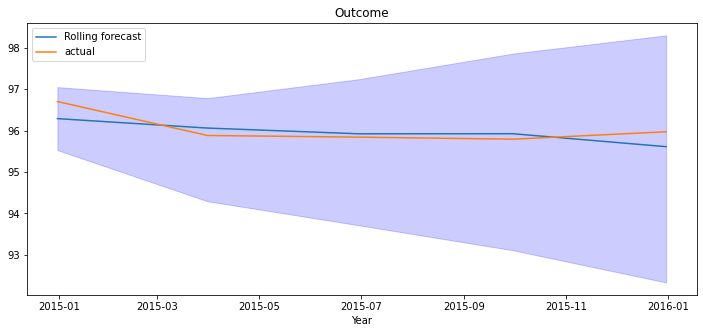

In [39]:
plt.figure(figsize = (12,5))
plt.plot(df_test.y, label = "Rolling forecast")  
plt.plot(df_test.x, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Year")
plt.show()